## Visualization of the flags

In [1]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

In [2]:
with open('RGBA_flags.pkl', 'rb') as f:
    flags = pickle.load(f)

with open('dataset.pkl', 'rb') as f:
    data = pickle.load(f)

### Most common color

In [73]:
from scipy.stats import mode

def get_RGB_mode(flags):
    flags = [flags[:,:,:3] for flags in flags]
    most_color = []
    for i in range(np.size(flags)):
        flatten = [e for sl in flags[i] for e in sl]
        a = mode(flatten, axis=0)[0][0]
        most_color.append(a)
    return most_color

In [ ]:
most_color = np.array(get_RGB_mode(flags))
continents = [int(x.replace(',', '')) for x in data[:, 1]]
populations = [int(x.replace(',', '')) for x in data[:, 2]]
wavelengths = [int(x.split('.')[0]) for x in data[:, 3]]

C:\Users\Fabio\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


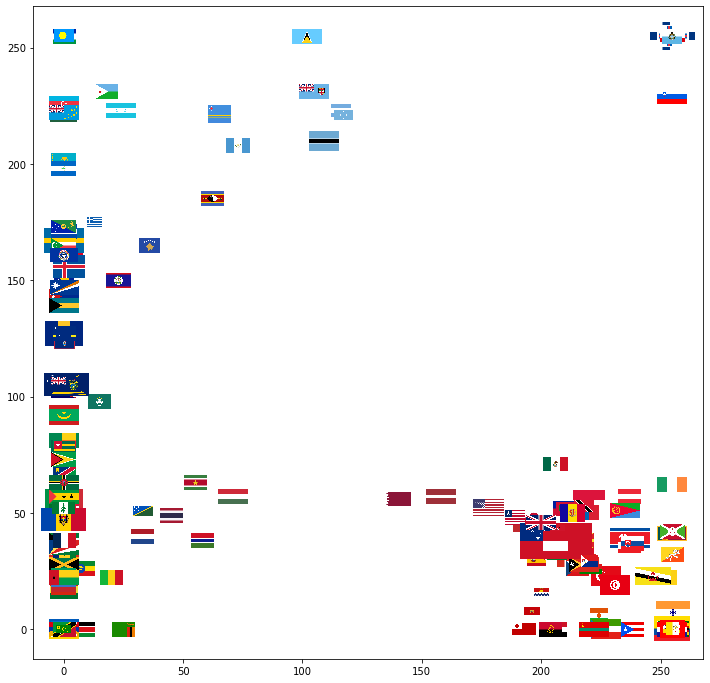

In [115]:
def scatter_flags(Xs, Ys, ims, ax=None, zoom=1):
    artists = []
    for X, Y, im in zip(Xs, Ys, ims):
        offim = OffsetImage(np.swapaxes(im, 0, 1), zoom=zoom)
        ab = AnnotationBbox(offim, (X, Y), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([Xs, Ys]))
    ax.autoscale()
    return artists

fig, ax = plt.subplots(figsize=(12, 12))
#scatter_flags(most_color[:, 2], populations, flags, ax=ax, zoom=0.025)
scatter_flags(most_color[:, 0], most_color[:, 2], flags, ax=ax, zoom=0.025)
#scatter_flags(np.mean(most_color,axis=1), populations, flags, ax=ax, zoom=0.025)
#plt.yscale('log')
#plt.savefig('flag_plot.png', dpi=500)
plt.show()

### Number of colors

In [324]:
def extract_all_colors(flag, min_percent=1e-2):
    flattened = flag.reshape(-1, flag.shape[-1])
    flattened[flattened > 250] = 250
    colors, counts = np.unique(np.round(flattened, -1), axis=0, return_counts=True)
    reduced_colors = colors[counts > flattened.shape[0] * min_percent]
    reduced_counts = counts[counts > flattened.shape[0] * min_percent]
    num_colors = len(reduced_counts)
    return reduced_colors, reduced_counts, num_colors

In [325]:
flag_colors, color_counts, num_colors = zip(*[extract_all_colors(flag) for flag in flags])

In [101]:
num_num_colors = np.zeros(np.max(num_colors) - np.min(num_colors) + 1)
order = np.zeros(len(num_colors))
for i in range(len(num_colors)):
    order[i] = num_num_colors[num_colors[i]-2]
    num_num_colors[num_colors[i]-2] += 1

In [102]:
def scatter_flags(Xs, Ys, ims, ax=None, zoom=1):
    artists = []
    for X, Y, im in zip(Xs, Ys, ims):
        offim = OffsetImage(np.swapaxes(im, 0, 1), zoom=zoom)
        ab = AnnotationBbox(offim, (X, Y), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([Xs, Ys]))
    ax.autoscale()
    return artists

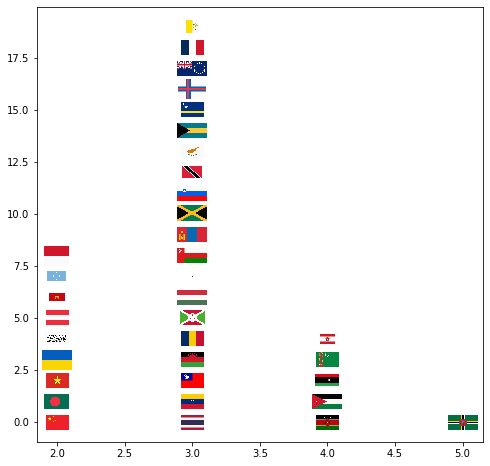

In [103]:
fig, ax = plt.subplots(figsize=(8, 8))
scatter_flags(num_colors, order, flags[::7], ax=ax, zoom=0.025)
plt.show()

### Aspect ratios

In [ ]:
import math

def aspectratio(image):
    width = image.shape[0]
    height = image.shape[1]
    gcd = math.gcd(width, height)
    return [width // gcd, height // gcd]

aspectratios = [aspectratio(flag) for flag in flags]

In [ ]:
ratio, count = np.unique(aspectratios, axis=0, return_counts=True)
ratio[count > 1]

array([[ 1,  1],
       [ 2,  1],
       [ 3,  2],
       [ 4,  3],
       [ 5,  3],
       [ 7,  4],
       [ 7,  5],
       [ 8,  5],
       [10,  7],
       [11,  8],
       [19, 10]])

### Complexity

In [200]:
def complexity(image):
    vertical_pixels = image.shape[0]
    horizontal_pixels = image.shape[1]
    vertical_change = np.mean(np.abs(image[:, :, :3] - np.roll(image[:, :, :3], shift=1, axis=0)))
    horzontal_change = np.mean(np.abs(image[:, :, :3] - np.roll(image[:, :, :3], shift=1, axis=1)))
    return (vertical_change*vertical_pixels + horzontal_change*horizontal_pixels)

complexities = [complexity(flag) for flag in flags]
complexities /= np.max(complexities)

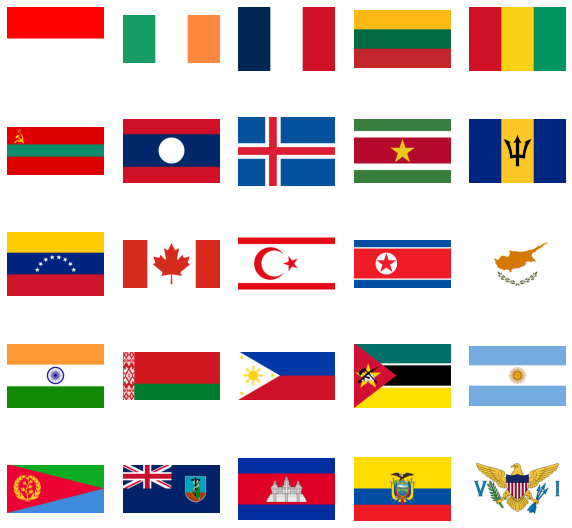

In [220]:
sort = np.argsort(complexities)
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i, s in enumerate(sort[::10]):
    ax[i//5, i%5].imshow(np.swapaxes(flags[s], 0, 1))
    ax[i//5, i%5].axis('off')

### Colors by continent

In [331]:
def get_continent_flag_colors(flag_colors, color_counts, continent_data, continent):
    country_idx = np.where(continent_data == continent)[0]
    flag_colors_continent = []
    color_percentages_continent = []
    for i in country_idx:
        color_ratios = color_counts[i] / np.sum(color_counts[i])
        for j in range(len(color_ratios)):
            if len(flag_colors_continent) == 0:
                flag_colors_continent.append(flag_colors[i][j])
                color_percentages_continent.append(color_ratios[j])
                continue
            deviation = np.linalg.norm(np.array(flag_colors_continent) - np.array(flag_colors[i][j]), axis=1)
            if np.min(deviation) > 0:
                flag_colors_continent.append(flag_colors[i][j])
                color_percentages_continent.append(color_ratios[j])
            else:
                pos = np.argmin(deviation)
                color_percentages_continent[pos] += color_ratios[j]
    return flag_colors_continent, color_percentages_continent / np.sum(color_percentages_continent)

In [361]:
flag_colors_continents = {}
color_percentages_continents = {}
for continent in ['Asia', 'Europe', 'Americas', 'Africa', 'Oceania']:
    flag_colors_continents[continent], color_percentages_continents[continent] = get_continent_flag_colors(flag_colors, color_counts, data[::, 1], continent)
    sorted_percentages = np.argsort(color_percentages_continents[continent])[::-1]
    flag_colors_continents[continent] = [flag_colors_continents[continent][i] for i in sorted_percentages]
    color_percentages_continents[continent] = color_percentages_continents[continent][sorted_percentages]

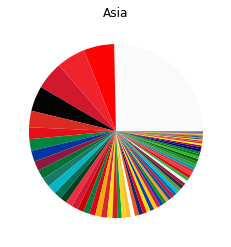

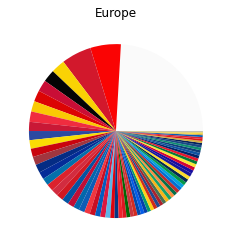

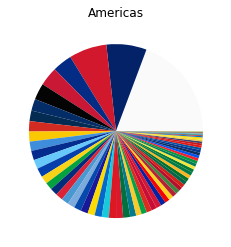

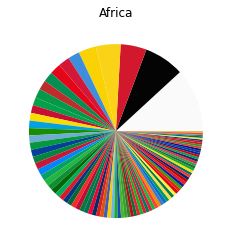

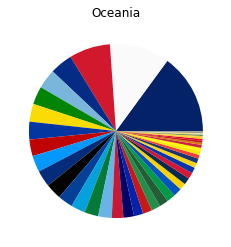

In [373]:
for continent in ['Asia', 'Europe', 'Americas', 'Africa', 'Oceania']:
    plt.title(continent)
    plt.pie(color_percentages_continents[continent], colors=np.array(flag_colors_continents[continent])/255)
    plt.show()

### Data exports

In [394]:
data_extended = np.c_[data[:, :3], num_colors, aspectratios, np.around(complexities, 3)]

In [397]:
import pandas as pd

df = pd.DataFrame(data_extended)

filepath = 'data_extended.xlsx'

df.to_excel(filepath, index=False)

In [400]:
import pickle

with open('colors_continent.pkl','wb') as f:
    pickle.dump([flag_colors_continents, color_percentages_continents], f)

In [401]:
with open('colors_continent.pkl','rb') as f:
    [flag_colors_continents, color_percentages_continents] = pickle.load(f)

Need
- Color decomposition by continent
- Amount of colors
- Complexity (Number of nonequivalent neighbors)
- Aspect ratios
- Population
- Symbols 
- Layout